In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score

from skopt import BayesSearchCV

In [3]:
data = pd.read_csv("dataset.csv")
data.head()

,SKU_ID,Date,Page_traffic,Revenue($),Unit_price,Units_sold,Segment,1_Star_Rating,2_Star_Rating,3_Star_Rating,...,Sum of Spend,Online_Clicks,Online_Cost,Online_Impressions,num_unique_campaigns,Clicks_video,Cost_video,Impressions_video,num_unique_campaigns_offline,Units_sold>1000
0,SKU1539,2022-04-09,5835.0,46006,22.214389,2071,Skincare,99.0,72.0,194.0,...,0.0,1271.0,3102.448115,238075.0,6.0,3479.0,40244.28,3856872.0,2.0,1
1,SKU1431,2021-05-08,1881.0,8084,11.870778,681,Skincare,118.0,73.0,200.0,...,0.0,494.0,1723.716359,75868.0,2.0,0.0,0.00,0.0,0.0,0
2,SKU995,2022-12-24,2477.0,24190,27.645714,875,Makeup,108.0,85.0,232.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0
3,SKU1136,2022-10-08,4087.0,23588,16.896848,1396,Makeup,82.0,64.0,167.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,1
4,SKU528,2022-03-26,1446.0,13446,16.357664,822,Hair Care,29.0,24.0,88.0,...,0.0,0.0,0.000000,0.0,0.0,6024.0,77040.81,7539723.0,2.0,0


## Feature Engineering 
Here we will do the below 
- Feature Transformation
- Feature Generation
- Feature Selection 

In [4]:
data.dtypes

SKU_ID                           object
Date                             object
Page_traffic                    float64
Revenue($)                        int64
Unit_price                      float64
Units_sold                        int64
Segment                          object
1_Star_Rating                   float64
2_Star_Rating                   float64
3_Star_Rating                   float64
4_Star_Rating                   float64
5_Star_Rating                   float64
Image_Count                     float64
Bullet_Count                    float64
Title_Count                     float64
Description_Length              float64
num_unique_Search_Terms         float64
Organic Search Rank             float64
Num_of_Promotions               float64
Sum of Spend                    float64
Online_Clicks                   float64
Online_Cost                     float64
Online_Impressions              float64
num_unique_campaigns            float64
Clicks_video                    float64


In [5]:
data.isnull().sum()

SKU_ID                          0
Date                            0
Page_traffic                    0
Revenue($)                      0
Unit_price                      0
Units_sold                      0
Segment                         0
1_Star_Rating                   0
2_Star_Rating                   0
3_Star_Rating                   0
4_Star_Rating                   0
5_Star_Rating                   0
Image_Count                     0
Bullet_Count                    0
Title_Count                     0
Description_Length              0
num_unique_Search_Terms         0
Organic Search Rank             0
Num_of_Promotions               0
Sum of Spend                    0
Online_Clicks                   0
Online_Cost                     0
Online_Impressions              0
num_unique_campaigns            0
Clicks_video                    0
Cost_video                      0
Impressions_video               0
num_unique_campaigns_offline    0
Units_sold>1000                 0
dtype: int64

### Label Encoding
Here Segment is Object which has three unique values, We can perform Label Encoding.

In [6]:
print(data['Segment'].value_counts())

Segment
Makeup       10631
Skincare      6362
Hair Care     2638
Name: count, dtype: int64


In [7]:
data['Segment'] = data['Segment'].map({
    "Makeup" : 1,
    "Skincare" : 2,
    "Hair Care": 3
})

In [8]:
data.isnull().sum()

SKU_ID                          0
Date                            0
Page_traffic                    0
Revenue($)                      0
Unit_price                      0
Units_sold                      0
Segment                         0
1_Star_Rating                   0
2_Star_Rating                   0
3_Star_Rating                   0
4_Star_Rating                   0
5_Star_Rating                   0
Image_Count                     0
Bullet_Count                    0
Title_Count                     0
Description_Length              0
num_unique_Search_Terms         0
Organic Search Rank             0
Num_of_Promotions               0
Sum of Spend                    0
Online_Clicks                   0
Online_Cost                     0
Online_Impressions              0
num_unique_campaigns            0
Clicks_video                    0
Cost_video                      0
Impressions_video               0
num_unique_campaigns_offline    0
Units_sold>1000                 0
dtype: int64

### Check for the outliers 

In [9]:
def handle_outliers( data, column_name):

    #calculate the 25th percentile, 75th percentile and IQR
    perc_25, perc_75 = np.percentile(data[column_name], [25,75])
    iqr = perc_75 - perc_25

    is_outlier_check = lambda x : ( (x > (perc_75 + 1.5*iqr)) or (x < (perc_25 - 1.5*iqr )) )

    is_outlier = data[column_name].apply(is_outlier_check)

    plt.figure(figsize=(5,5))

    sns.boxplot(data=data, x=column_name)
    plt.title(f"Boxplot for {column_name}, Outlier Count : {sum(is_outlier)}")

    plt.show()
    plt.close()

    return perc_25, perc_75, data[column_name].clip(lower = perc_25 - 1.5 * iqr,
                                                    upper = perc_75 + 1.5 * iqr).values

In [10]:
data.drop(['Units_sold','SKU_ID','Revenue($)','Units_sold'], inplace=True, axis=1)

In [11]:
data.columns

Index(['Date', 'Page_traffic', 'Unit_price', 'Segment', '1_Star_Rating',
       '2_Star_Rating', '3_Star_Rating', '4_Star_Rating', '5_Star_Rating',
       'Image_Count', 'Bullet_Count', 'Title_Count', 'Description_Length',
       'num_unique_Search_Terms', 'Organic Search Rank', 'Num_of_Promotions',
       'Sum of Spend', 'Online_Clicks', 'Online_Cost', 'Online_Impressions',
       'num_unique_campaigns', 'Clicks_video', 'Cost_video',
       'Impressions_video', 'num_unique_campaigns_offline', 'Units_sold>1000'],
      dtype='object')

In [ ]:
for column in data.columns:
    print(column)
    if pd.api.types.is_numeric_dtype(data[column]) and not pd.api.types.is_bool_dtype(data[column]):
        per_25, per_75, data[column] = handle_outliers(data, column)

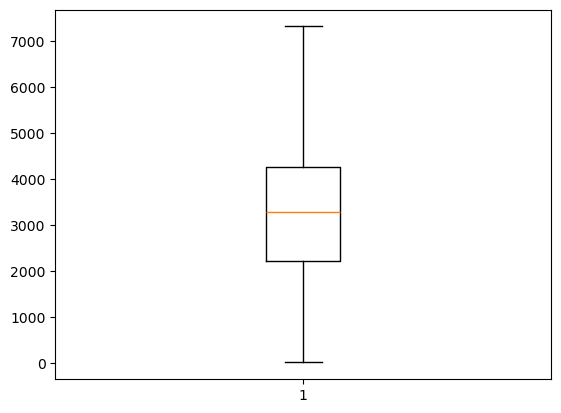

In [13]:
plt.boxplot(data["Page_traffic"])
plt.show()

## Feature Generation

In [14]:
#Calculate the weighted average [10, 20, 30] the 1*20 + 2*20 + 3*30 / (10+20+30 +1)
weighted_average_rate = lambda x: np.round( sum( i*val for i , val in enumerate(x, start=1)) / (sum(x) + 1E-15), 1 )

In [15]:
#Extract the column containing the Star Rating 
rating_columns = data.columns[data.columns.str.contains('Star_Rating')]
rating_columns

Index(['1_Star_Rating', '2_Star_Rating', '3_Star_Rating', '4_Star_Rating',
       '5_Star_Rating'],
      dtype='object')

In [16]:
data['weighted_average_ratings'] = data[rating_columns].apply(weighted_average_rate, axis=1)
data['weighted_average_ratings'].describe()

count    19631.000000
mean         3.908746
std          1.549840
min          0.000000
25%          4.500000
50%          4.600000
75%          4.600000
max          4.900000
Name: weighted_average_ratings, dtype: float64

In [17]:
#online cost per impression for online ads, higher indicates less efficient, require high expenditure
data['online_cost_per_impression'] = data['Online_Cost'] / data['Online_Impressions']

# cost of video ad campaign
data['video_cost_per_impression'] = data['Cost_video'] / data['Impressions_video']


# Total Cost 
data['total_cost'] = data['Online_Cost'] + data['Cost_video']

In [18]:
data['Date'] = pd.to_datetime(data['Date'], format="%Y-%m-%d")
data['month'] = data['Date'].dt.month
data['is_month_end'] = data['Date'].dt.is_month_end

In [27]:
data[data.isnull().sum()!=0]

C:\Users\User\AppData\Local\Temp\ipykernel_19216\1723060919.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data.isnull().sum()!=0]


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

# Creating Dependent and Independent features for training

In [19]:
X = data.drop(['Units_sold>1000'] , axis=1)
y = data['Units_sold>1000']

# Split data into train , validation and test dataset

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [21]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=33)

In [22]:
(len(x_train), len(x_test), len(x_val))

(12563, 3927, 3141)

# Model Performance 

In [23]:
def validate_model(x_train, y_train, x_val, y_val, model=None):
    if model is None:
        model = GradientBoostingClassifier(max_depth=7, min_samples_leaf=25,n_estimators=110, random_state=40)

    model.fit(x_train, y_train)

    train_f1_score = f1_score(y_train, model.predict(x_train))
    val_f1_score = f1_score(y_val, model.predict(x_val))

    print(f"F1 Score on training data  {train_f1_score}")
    print(f"F1 Score on Validation data {val_f1_score}")


In [24]:
validate_model(x_train, y_train, x_val, y_val)

DTypePromotionError: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.DateTime64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Int32DType'>, <class 'numpy.dtypes.BoolDType'>)